# Federated Machine Learning

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices. This notebook is part of a series intended to demonstrate federated learning, then move on to test some of the bounds of what federated learning can (and can't) do. We'll be using `pytorch` as our machine learning tool.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model from the [`pytorch` example code](https://github.com/pytorch/examples/blob/master/mnist/main.py) (to keep it simple and to keep the focus on federation, we'll be using whatever we can from the standard `pytorch` examples).

## The Approach to Demonstrate: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a common model, then sends the new common model back to the workers. This unit of processing is called a _round_. 

Then another round begins: the workers each train their local copy of the common model (creating another set of individualized local models), send those updated local models back to the manager. Once again the manager combines these individualized local models into a new common model, and pushes the new common model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

# Common Elements

Let's first set a baseline so we have a point of reference for our federated approach. To keep the comparisons useful, we'll use the same overall dataset and neural network in the baseline case as we do in the federated cases. Let's set those up here.

## The Data - Standard MNIST Datasets
Here we get the MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms and normalization parameters as the ['pytorch' example code](https://github.com/pytorch/examples/blob/master/mnist/main.py). The standard MNIST training and test datasets, contain 60,000 and 10,000 examples, respectively.

Pytorch uses `DataLoader`s for training. We'll be working with a lot of them here. A `DataLoader` contains a `Dataset` and training parameters like `batch_size`. We'll make a couple of standard `DataLoader`s with the parameters used in the [`pytorch` example code](https://github.com/pytorch/examples/blob/master/mnist/main.py). These contain the 60,000-example training `Dataset` and the 10,000-example test `Dataset`.

In [1]:
from mnist_utils import get_MNIST_dataloaders

default_training_dataloader, default_testing_dataloader = get_MNIST_dataloaders()

default_training_dataset = default_training_dataloader.dataset
default_testing_dataset = default_testing_dataloader.dataset

print("Training dataset size: ", len(default_training_dataset))
print("Testing dataset size : ", len(default_testing_dataset))

Training dataset size:  60000
Testing dataset size :  10000


I'm being super explicit about the digit counts and distributions here, because we're going to be doing some fancy footwork with them later on. So we need to know what we're starting with. So let's check out the default MNIST data.

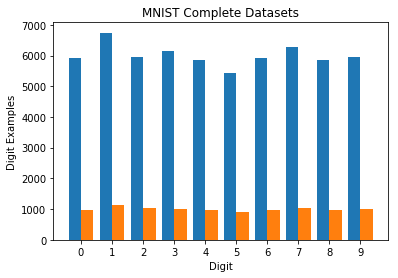

In [2]:
from mnist_utils import plot_digit_histogram

plot_digit_histogram([default_training_dataloader, default_testing_dataloader], title='MNIST Complete Datasets')

The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many samples of `4`s as `6`s (though the set is a *little* heavy on `1`s and a *little* light on `5`s). The test set (orange) counts are smaller than the training set (blue) counts by a factor of six, which reflects the relative sizes of the datasets.

## Baseline: The Non-Federated Approach
To show baselines of non-federated learning, we'll train a model the traditional way.

### The Perfect World: All the Data in One Place

We're testing an ideal non-federated situation: all of our data is in one place to train a single model. To do this we'll train that single model with all of the data in the MNIST training set, 60,000 examples. We'll set a default number of rounds to train. In the non-federated case, a round is equivalent to an epoch.

In [3]:
print("Dataset size: ", len(default_training_dataloader.dataset))

# default training rounds
default_n_rounds = 3

# target for early stopping (we'll use this later to compare approaches)
default_target_accuracy = 90.0

Dataset size:  60000


Our model in all of these examples is the convolutional neural network used in the [`pytorch` sample code](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [4]:
from mnist_utils import DefaultNet

model = DefaultNet()

Now we train without federation.

In [5]:
import torch
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from mnist_utils import split_dataset


n_epochs = default_n_rounds


#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

optimizer = torch.optim.Adadelta(model.parameters(), lr=1.) # this is used in the example code
loss_function = torch.nn.CrossEntropyLoss()

dataloader = default_training_dataloader
test_samples, test_labels = split_dataset(default_testing_dataset)

history = {'test_loss': [], 'test_accuracy': []}

for epoch in trange(n_epochs):
    
    #train
    model.train(True)
    for i, (training_samples, training_labels) in enumerate(dataloader):
        optimizer.zero_grad()
        training_predictions = model(training_samples)
        training_loss = loss_function(training_predictions, training_labels)
        training_loss.backward()
        optimizer.step()

    #test
    model.train(False)
    with torch.no_grad():
        output = model(test_samples)
        test_loss = loss_function(output, test_labels).item()
        test_predicted_classes = output.argmax(dim=1, keepdim=True)
        n_correct = test_predicted_classes.eq(test_labels.view_as(test_predicted_classes)).sum().item()
    accuracy = (n_correct / len(test_labels)) * 100.

    #record loss and accuracy
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(accuracy)
    print('Round: {} loss: {:.4f} accuracy: {:.2%}'.format(epoch, test_loss, accuracy / 100.))

Round: 0 loss: 0.0560 accuracy: 98.26%
Round: 1 loss: 0.0417 accuracy: 98.57%
Round: 2 loss: 0.0414 accuracy: 98.94%



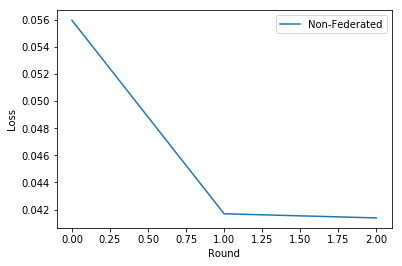

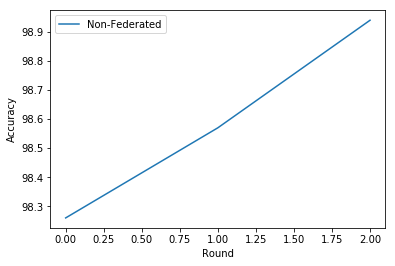

In [6]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(history['test_loss'], label='Non-Federated')
ax.set_xlabel("Round")
ax.set_ylabel("Loss")
ax.legend();

fig, ax = plt.subplots()
ax.plot(history['test_accuracy'], label='Non-Federated')
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.legend();

So there's our baseline ideal-world situation, a non-federated model trained with all 60,000 data points in front of it.

# The Federated Approach

Now that we have a baseline using the traditional, i.e., non-federated, approach, let's see what federation gets us (and doesn't). We'll do the same MNIST task using federation.

## Our Federation Code

The federation code we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. As a result of being on one machine, it does not have to deal with network communication or the timing problems inherent to real parallelism. But in our toy example the "local" models are independent in that they do not share data nor local models (except to the extent their models are combined) and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a common prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

### Comment
This is fine but There's some text I used to explain why this "not true federated learning" thing doesn't mean what you're reading is useless. I like "algorthmically faithful". It's also a bit tricky to explain what this simulation approach _doesn't_ do (network traffic, race conditions, etc.) until you've explained the algorithm. So I think this section needs a bit of work.

Also the heading is not a good indication of its purpose. This is in some ways the most important bit of the article for a reader who is new to FL! It's the bit where we explain what FL is!

Can we use some figures from the report to make it easier to follow?

Also, backing up a bit: I'm not sure you explain _why_ you want to do FL in the first place at any point in this article (privacy, bandwidth, power, etc.) That needs to be somewhere early, probably right at the top, and then repeated immediately after you explain the algorithm: i.e. the algorithm takes care of the concerns I mentioned at the top.

"Our library": unless you move it into a py file it's not really a library.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated common model and pushes that new common model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

```
N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N
```

Thats the whole combination function, an item-wise average of the model weights.

## Splitting the Deck Into Piles for Federation

To illustrate federated learning we use several workers, each representing a remote device. We'll use ten workers here, and for now, we'll assume each of our ten workers has roughly equal types and quantities of data to the other nine (to do this we use `p=0` to reflect roughly even distribution of digit samples for any one worker).

### Comment 
I would prefer the variable names to be less crpytic (no abbreves) given the goals. I also think this would be better in a library. These functions are super fiddly and not really about FL. We can explain them with the plots.

We're going to have ten workers. So we allocate each example in the 60,000 sample MNIST training set to one worker. We do this by making ten torch DataLoaders, one for each worker.

In [7]:
from mnist_utils import make_federated_dataloaders

fed_equal_dls = make_federated_dataloaders(default_training_dataset)


### TODO - USE MORE FLEXIBLE VERSION?

Let's see how the allocation worked.

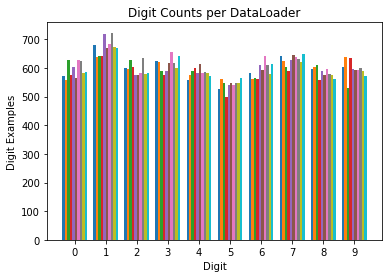

In [8]:
#show the counts of examples allocated to each of the DataLoaders (workers
plot_digit_histogram(fed_equal_dls, 'Digit Counts per DataLoader')

We can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

## Federated Training
Now let's train the federated system.

In [9]:
from federated import FederatedManager
from federated import FederatedWorker

fed_equal_mgr = FederatedManager('Federated Unbiased', fed_equal_dls, default_testing_dataset, DefaultNet)

fed_equal_mgr.learn(default_n_rounds, default_target_accuracy)

Federated Unbiased manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.


Federated Unbiased manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 91.66% and loss 0.2874.)


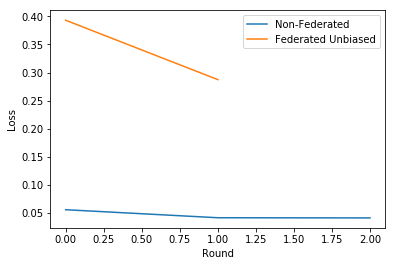

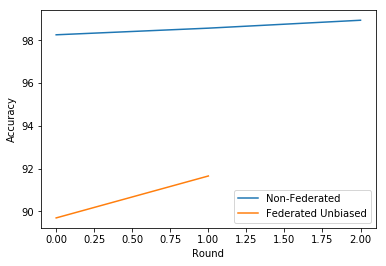

In [10]:
from federated import plot_managers

nonfed_alldata_mgr = FederatedManager('Non-Federated', [default_training_dataloader], default_testing_dataset, DefaultNet)
nonfed_alldata_mgr.history = history

plot_managers([nonfed_alldata_mgr, fed_equal_mgr])

The federated model converges, though a little slower than the non-federated version. But in the federated model, we don't have to move any data to a central system.

So we know that there's a performance cost (slower convergence and possibly lower accuracy) to using federation compared to moving all of the data to a central model. But this comparison isn't quite apples to apples. If moving all of the data isn't possible or desirable, the options are federation or just using the local data for each model. So let's compare those.

### Comment
I don't think this comparison is necessary for the goals of the post, but thanks for doing it!

In [11]:
nonfed_subset_mgr = FederatedManager('Non-Federated Limited Unbiased', [make_federated_dataloaders(default_training_dataset, p=0.0)[7]], default_testing_dataset, DefaultNet)
nonfed_subset_mgr.learn(default_n_rounds, default_target_accuracy)

Non-Federated Limited Unbiased manager training with 1 worker(s) for up to 3 rounds or 90.00% accuracy.


Non-Federated Limited Unbiased manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 90.51% and loss 0.3160.)


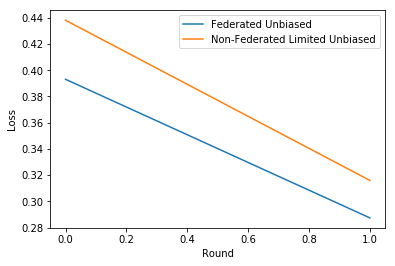

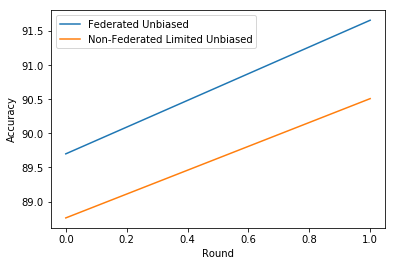

In [12]:
plot_managers([fed_equal_mgr, nonfed_subset_mgr])

The federated manager, which uses all the data, but doesn't have all the data in one place, matches or outperforms the non-federated model. In other words, performance improves with the additional signal made available by federation, and without the cost and risk of data transfer from the worker devices.

Of course, this isn't a guarantee in every case, but it shows the mechanics and potential of federation.

### Non-Federated Learning With Limited Data

In the real world, independent devices won't have all the data in front of them, and there will be bias in the data they see. E.g., a smartphone won't have access to other user's data to train a predictive text model. So let's see what happens when we simulate just one device with less data and some skew in that limited data.

The code below slices up the standard MNIST dataset and samples it without replacement to make ten subsets, then makes a dataloader for each of the ten subsets. The parameter `p` reflects the amount of skew in the dataset. There's also a dataset inspection function and an eval function for doing a whole simulation on one line.

### Comment
I also don't think this section is necessary. I mean logically it's necessary to prove your point, but it's not necessary to make sense of the article. I would drop it.

We'll make a sample dataset with about 6,000 training samples, one tenth of the total MNIST training set. We'll arbitrarily choose the digit `4` for our overweighted digit, and a relatively mild skew value of `p=0.25`. 


Dataset size:  5997


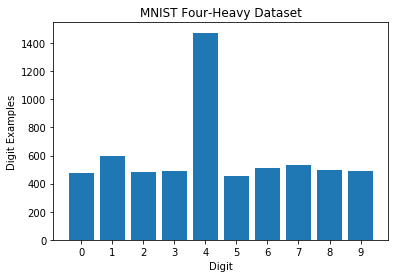

In [13]:
# Make a set of DataLoaders and use the one that is skewed toward 4s

nonfed_four_dl = make_federated_dataloaders(default_training_dataset, p=0.25)[4]

plot_digit_histogram([nonfed_four_dl], 'MNIST Four-Heavy Dataset')

print("Dataset size: ", len(nonfed_four_dl.dataset))

Here's what our dataset looks like. About a tenth of the samples and heavy on the 4s.

Now let's see what happens when we train with this subset. As before, we won't use any federation here, just less data and a little bias in the data we do have.

Non-Federated Fours Biased 0.25 manager training with 1 worker(s) for up to 3 rounds or 90.00% accuracy.


Non-Federated Fours Biased 0.25 manager stopped: met accuracy target of 90.00% after 3 rounds. (Test accuracy 90.23% and loss 0.3125.)


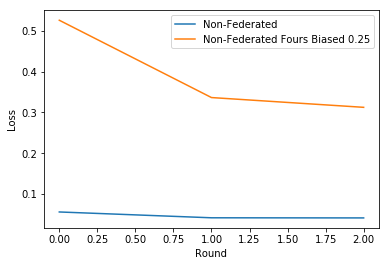

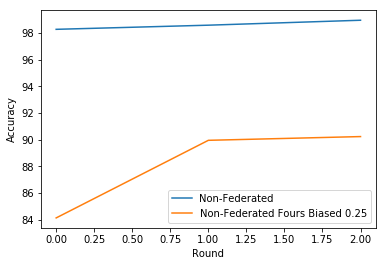

In [14]:
nonfed_four_mgr = FederatedManager('Non-Federated Fours Biased 0.25', [nonfed_four_dl], default_testing_dataset, DefaultNet)
nonfed_four_mgr.learn(default_n_rounds, default_target_accuracy)
plot_managers([nonfed_alldata_mgr, nonfed_four_mgr])

We should see that the limited-data model converges more slowly than the full data model. (I say "should" because these are randomly sampled datasets we're building - there's always a very small chance we'll get an unlucky draw.)

# Federation with Varying Example Distributions Per Worker

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially worse than the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Decks into Uneven Piles

To test this, we need workers to have access to varying numbers of examples across training classes. So let's make a set of dataloaders that will give each worker more examples of a given digit than the other workers.

The parameter `p` sets the degree of bias toward the overweighted digit in each dataloader. Specifically, `p` is the odds of an example from a specific class being selected for a worker from the base dataset. We'll use `0.15` for `p` for now.

This results in a set of stacked dataloaders. The number of dataloaders is equal to the number of classes. Each dataloader is overweighted to exactly one digit class.

In [15]:
fed_weighted_dls = make_federated_dataloaders(default_training_dataset, p=0.4)
worker_example_counts = [len(dataloader.dataset) for dataloader in fed_weighted_dls]

print(worker_example_counts)
print(sum(worker_example_counts))

[6016, 6123, 6100, 6148, 5944, 5717, 5895, 6213, 5910, 5934]
60000


Note that the dataloaders still give each worker roughly the same *total number* of examples. It's the number of examples *per class* that varies. And each of the 60,000 examples in the MNIST training dataset is allocated (without replacement) to a worker, so the total number of examples across workers is 60,000.

Let's look at how the digit examples are allocated within each worker.

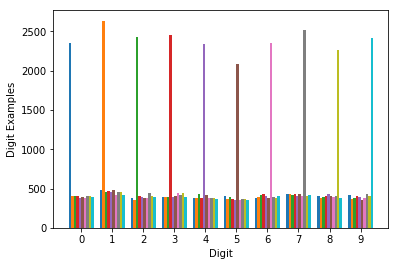

In [16]:
plot_digit_histogram(fed_weighted_dls)

We see here that worker 4, shown in purple, has more examples of the digit `4` than other workers. Likewise, worker 6, shown in pink, has more examples of the digit `6` than other workers.

Here are the actual counts from the dataloaders for workers 4 and 6. You can see that the most frequent examples in those dataloaders are `4` and `6`, respectively.

In [17]:
from mnist_utils import check_datasets

check_datasets([fed_weighted_dls[4].dataset])

check_datasets([fed_weighted_dls[6].dataset])

Counter({4: 2343, 1: 459, 8: 429, 6: 402, 7: 401, 3: 398, 9: 393, 2: 388, 0: 374, 5: 357})
Counter({6: 2347, 3: 447, 1: 420, 7: 408, 8: 390, 2: 385, 4: 383, 0: 382, 9: 376, 5: 357})


And if you're curious, here are all of the worker counts.

In [18]:
check_datasets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 2355, 1: 476, 7: 424, 9: 416, 5: 410, 8: 403, 3: 394, 4: 384, 2: 379, 6: 375})
Counter({1: 2636, 7: 428, 0: 411, 6: 398, 3: 386, 4: 385, 8: 384, 5: 371, 9: 369, 2: 355})
Counter({2: 2423, 1: 460, 4: 428, 7: 415, 6: 412, 0: 406, 8: 398, 3: 392, 5: 392, 9: 374})
Counter({3: 2455, 1: 467, 7: 431, 6: 428, 9: 411, 0: 406, 2: 402, 8: 399, 4: 385, 5: 364})
Counter({4: 2343, 1: 459, 8: 429, 6: 402, 7: 401, 3: 398, 9: 393, 2: 388, 0: 374, 5: 357})
Counter({5: 2084, 1: 486, 7: 424, 4: 413, 8: 406, 3: 402, 0: 387, 6: 382, 2: 378, 9: 355})
Counter({6: 2347, 3: 447, 1: 420, 7: 408, 8: 390, 2: 385, 4: 383, 0: 382, 9: 376, 5: 357})
Counter({7: 2515, 1: 462, 2: 445, 9: 432, 3: 418, 0: 402, 8: 400, 6: 393, 4: 376, 5: 370})
Counter({8: 2267, 1: 455, 3: 445, 0: 409, 9: 407, 7: 406, 2: 405, 4: 375, 6: 375, 5: 366})
Counter({9: 2416, 1: 421, 7: 413, 6: 406, 2: 398, 3: 394, 0: 391, 8: 375, 4: 370, 5: 350})


Now let's see how the federated approach performs with variation in the worker datasets.

Fed Bias manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.


Fed Bias manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 91.09% and loss 0.3135.)


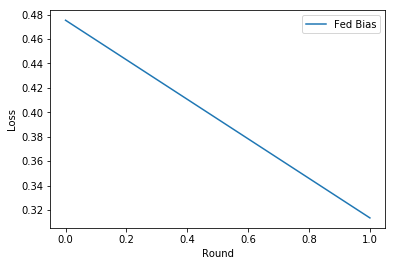

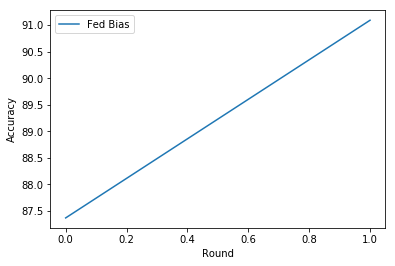

In [19]:
fed_weighted_mgr = FederatedManager('Fed Bias', fed_weighted_dls, default_testing_dataset, DefaultNet)
fed_weighted_mgr.learn(default_n_rounds, default_target_accuracy)
plot_managers(fed_weighted_mgr)

The biased federated model converges just fine.

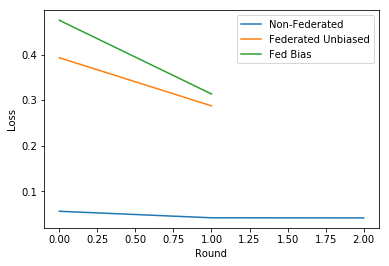

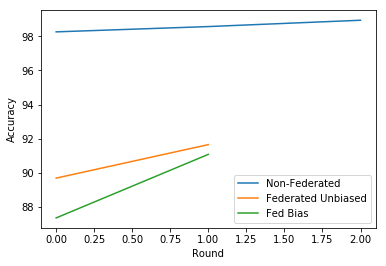

In [20]:
plot_managers([nonfed_alldata_mgr, fed_equal_mgr, fed_weighted_mgr])

Though it converges a little slower than the unbiased federated model.

Let's take a closer look at how performance changes with increasingly biased data.

Fed Bias 0.0 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.


Fed Bias 0.0 manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 92.28% and loss 0.2742.)
Fed Bias 0.4 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.


Fed Bias 0.4 manager stopped: met accuracy target of 90.00% after 2 rounds. (Test accuracy 91.23% and loss 0.3096.)
Fed Bias 0.8 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.


Fed Bias 0.8 manager stopped: met accuracy target of 90.00% after 3 rounds. (Test accuracy 90.35% and loss 0.3520.)
Fed Bias 0.9 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.



Fed Bias 0.9 manager trained 3 rounds. (Test accuracy 86.63% and loss 0.5113.)
Fed Bias 0.95 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.



Fed Bias 0.95 manager trained 3 rounds. (Test accuracy 83.70% and loss 0.7784.)
Fed Bias 0.98 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.



Fed Bias 0.98 manager trained 3 rounds. (Test accuracy 72.75% and loss 1.3875.)
Fed Bias 0.99 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.



Fed Bias 0.99 manager trained 3 rounds. (Test accuracy 69.53% and loss 1.7803.)
Fed Bias 1.0 manager training with 10 worker(s) for up to 3 rounds or 90.00% accuracy.



Fed Bias 1.0 manager trained 3 rounds. (Test accuracy 62.56% and loss 1.7748.)



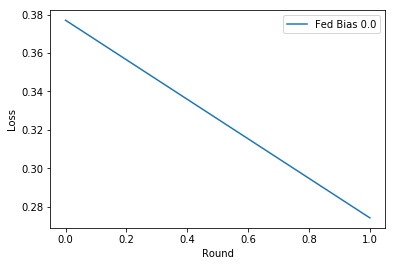

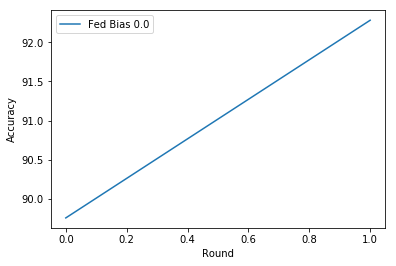

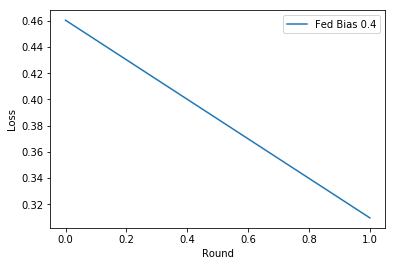

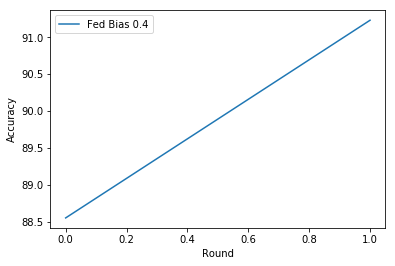

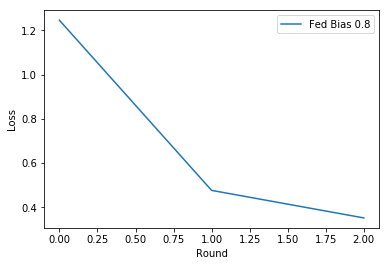

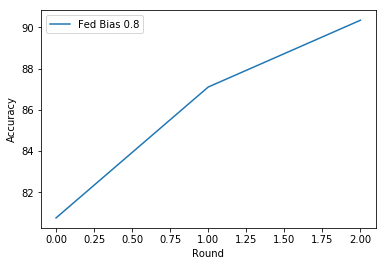

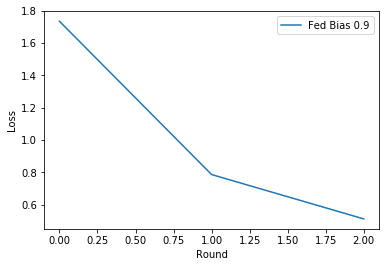

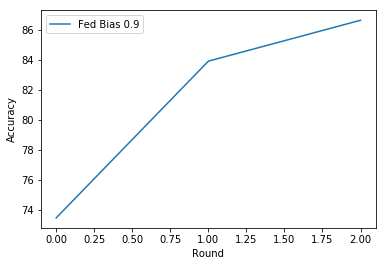

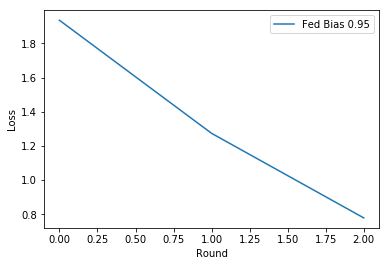

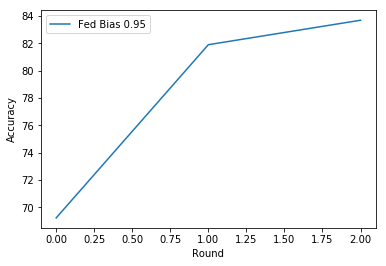

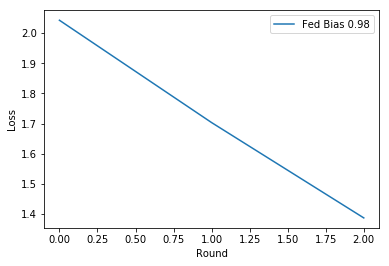

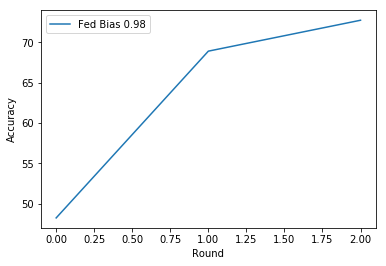

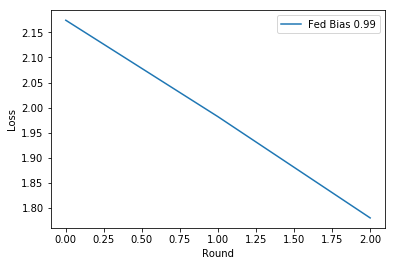

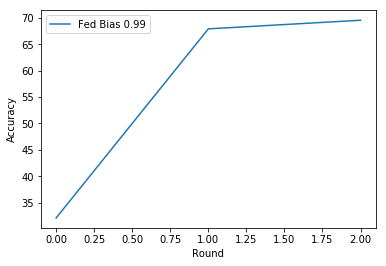

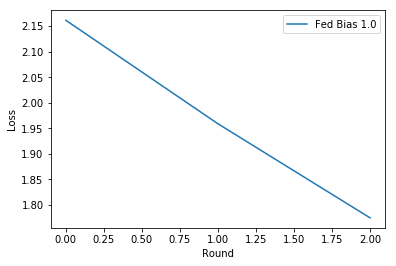

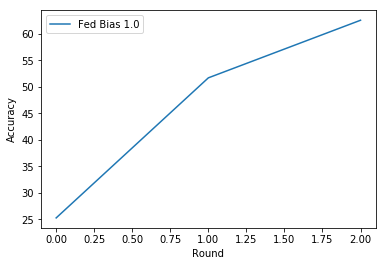

In [21]:
from federated import evaluate_new_manager

#mgrs = evaluate_new_manager('Fed Bias '+ str(0.0), train_dset, test_dset, p=0.0, n_rounds=default_n_rounds, target_accuracy=default_target_accuracy, model=DefaultNet)

mgrs = [evaluate_new_manager('Fed Bias '+ str(bias), default_training_dataset, default_testing_dataset, p=bias, n_rounds=default_n_rounds, target_accuracy=default_target_accuracy, model=DefaultNet) for bias in tqdm([0.0, 0.4, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0], desc='Managers')]

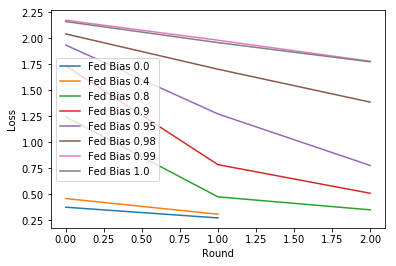

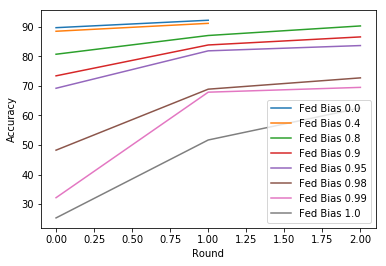

In [22]:
plot_managers(mgrs)

The federated models converge even with very heavily biased datasets per worker. Unsurprisingly, it takes longer to hit a given target accuracy. But even when the datasets are completely biased, that is, each worker sees examples from *exactly one class*, a federated set of workers can still at least converge.

In cases of heavily skewed datasets, federation enables the common model to incorporate signal from sources that operate only as sensors for outlier data.

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE